# Optimum Filter Demo: NxMx1 Covariance Matrix

Author: Maggie Reed, maggie_reed@berkeley.edu

Last updated: 06/30/2024

-----

UNDERCONSTRUCTION! DETPROCESS SIGNAL PROCESSING IS NOT IMPLEMENTED YET.

# Overview and Purpose

This demo notebook is for Spice/Herald members who wish to utilize the NxMx1 covariance matrix for optimum filter formalism. 

blahblahstuff about filters and the nxm 

# Setup

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import qetpy as qp
import pytesdaq
import numpy as np

In [3]:
save_dict_name = 'didvresult_muon_example'
with open(save_dict_name, 'rb') as handle:
    offsets_dict = pickle.load(handle)

In [4]:
fs=1.25e6
f = np.fft.fftfreq(32768, d=1/fs)
noisesim = qp.sim.TESnoise(freqs=f, didv_result=offsets_dict)
psd_sim = noisesim.s_iload(freqs=f) + noisesim.s_ites(freqs=f) + noisesim.s_itfn(freqs=f)
# create 100 noise traces for each pulse
noise = qp.gen_noise(psd_sim, fs=fs, ntraces=100)
noise2 = qp.gen_noise(psd_sim, fs=fs, ntraces=100)

f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs)

# create a template
pulse_amp = 1.6e-6 # [A]
tau_f = 66e-6 # [s]
tau_r = 20e-6 # [s]

t = np.arange(len(psd_sim))/fs
pretrigger_samples = len(t)//2
pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r) #just the basic equation for a pulse
pulse_shifted = np.roll(pulse, len(t)//2) #shifting the pulse to the center of t
template = pulse_shifted/pulse_shifted.max() #normalized template to max height of pulse
# use the PSD to create an example trace to fit
signal_1 = noise[0] + np.roll(template, 160)*pulse_amp # note the shift we have added, 160 us

# create a second signal, different shape, same length. Signal occurs at same time. 
# noise is the exact same 
pulse_amp = 1.6e-6 # [A]
tau_f = 120e-6 # [s]
tau_r = 20e-6 # [s]
pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)
template2 = pulse_shifted/pulse_shifted.max()
signal_2 = noise2[0] + np.roll(template2, 160)*pulse_amp 

Automatically determining G
P0 = 50.72686520007603 fW
G = 6.340858150009502e-12 W/K
Calculating dVdI
Calculating dPdI


/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1731: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[0] = _ddi0_dPdI_3(didv_result, f)
/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1732: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[1] = _ddr0_dPdI_3(didv_result, f)
/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1733: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[2] = _dddVdI_dPdI_3(didv_result, f)
/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1734: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[3] = _ddbeta_dPdI_3(didv_result, f)
/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:

Done calculating dVdI and dPdI


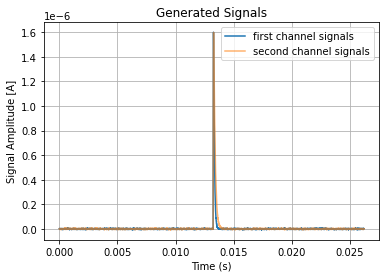

In [5]:
plt.plot(t, signal_1, label='first channel signals')
plt.plot(t, signal_2, alpha=0.6,label='second channel signals')
plt.ylabel("Signal Amplitude [A]")
plt.xlabel("Time (s)")
plt.grid()
plt.legend()
plt.title('Generated Signals')
plt.show()

In [6]:
nchans=2
nbins=len(signal_1)

avgnoise_matrix = np.zeros((100,nchans,nbins)) #calculating csd from 100 traces of noise
avgnoise_matrix[:,0,:] = noise
avgnoise_matrix[:,1,:] = noise2

chans = ['signal1','signal2']
NC = qp.Noise(avgnoise_matrix, fs, chans)
NC.calculate_csd(twosided=True) #csd is returned in A^2/Hz
csd = NC.csd

noise_matrix = np.zeros((nchans,nbins))
noise_matrix[0,:]=noise[0] #just taking one noise trace
noise_matrix[1,:]=noise2[0]

# 2x2

I am running into some difficulty on creating the matrix for the templates correctly. The template matrix is built by looping over channels and template tags: 

    for ichan, chan in enumerate(channels):

            channels_templates = list(self._templates_fft[chan].keys())
            
            for itag, tag in enumerate(channels_templates):
            
                temp_templ_fft = self._templates_fft[chan][tag]
                
                temp_templ_fft[np.isnan(temp_templ_fft)] = 0
                
                temp_templ_mat[ichan,itag,:]  = temp_templ_fft*self._df
                
        self._template_mat[channel_name] = temp_templ_mat
        
If we wanted to do the 2x2, where each channel will have its own template, our template matrix would have dimensions: [nchan, ntmp, nbins] or [2,2,nbins]. Where [0,0,nbins] is the first channels only template. And [1,0,nbins] is the second channels only template. However, constructing the template matrix as above works well for Praytush's case, but not for a 2x2 case. You can see below what happens. The template matrix gets extra mixing terms between templates, which ultimately halves the amplitude size of each fit. In other words, we have the following: 

for the first channel: [0,0,nbins] this is correct, it is the first channels template. 

But it also has: [0,1,nbins]. This is not correct. This is attaching the template for the second channel to the first.

for the second channel: [1,0, nbins] AND [1,1,nbins]. The second one is correct. The first one is mixing terms. 

Trying just one template tag does not work either, as it generates just one amplitude of the correct size, but not two amplitudes (one for each channel) as we wanted. 

The way to build the template that would work in this case is to make off diagn terms zero like this:

for the first channel: [0,0,nbins]

for the second channel: [1,1,nbins]

Where [0,1,nbins] is just zeros and [1,0,nbins] is also just zeros. 

But building the template matrix so off diagn terms are zeros would mess up Praytush/Herald case I think???? 

In [11]:
templates = np.array([template,template2])
signal = np.array([signal_1,signal_2])

# in format 'chan1|chan2' OR 'chan1 | chan2' 
channels = 'signal_1 | signal_2'

template_tags=['template1', 'template2']

pretrigger_samples = nbins//2


In [8]:
from qetpy.core import OFnxm
from qetpy.core import OFBase

In [12]:
ofnxm = OFnxm(template_tags=template_tags, channels=channels, 
              templates=templates, csd=csd,sample_rate=fs, 
              pretrigger_samples=pretrigger_samples)

INFO: Adding template with tag template1 to OF base object. Channel issignal_1
INFO: Adding template with tag template2 to OF base object. Channel issignal_1
INFO: Adding template with tag template1 to OF base object. Channel issignal_2
INFO: Adding template with tag template2 to OF base object. Channel issignal_2
INFO: Adding noise CSD to OF base object
The noise csd has been calculated: 
[[ 8.91019072e+20+0.j -3.73140808e+19+0.j]
 [-3.73140808e+19+0.j  8.94507924e+20+0.j]]


In [13]:
ofnxm.calc(channels=channels, signal=signal)
amp, t0, chi2 = ofnxm.get_fit_withdelay(channels=channels, signal=signal)
print(f"With Delay Fit: amp = {amp*1e6} uA, t_0 = {t0*1e6} us, chi^2 = {chi2}")


With Delay Fit: amp = [0.78937326 0.81232248] uA, t_0 = 128.0 us, chi^2 = 296973.3650696315


# 2x1

In [14]:
templates = np.array([template,np.zeros_like(template)])
signal = np.array([signal_1,noise2[0]]) #our signal on the second channel is just noise

# in format 'chan1|chan2' OR 'chan1 | chan2' 
channels = 'signal_1 | signal_2'

template_tags=['template1', 'Nosignal']

pretrigger_samples = nbins//2

In [15]:
ofnxm = OFnxm(template_tags=template_tags, channels=channels, 
              templates=templates, csd=csd,sample_rate=fs, 
              pretrigger_samples=pretrigger_samples)

INFO: Adding template with tag template1 to OF base object. Channel issignal_1
INFO: Adding template with tag Nosignal to OF base object. Channel issignal_1
INFO: Adding template with tag template1 to OF base object. Channel issignal_2
INFO: Adding template with tag Nosignal to OF base object. Channel issignal_2
INFO: Adding noise CSD to OF base object


/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/_of_base.py:617: RuntimeWarning: invalid value encountered in true_divide
  template = template/np.max(template)


The noise csd has been calculated: 
[[ 8.91019072e+20+0.j -3.73140808e+19+0.j]
 [-3.73140808e+19+0.j  8.94507924e+20+0.j]]


In [16]:
ofnxm.calc(channels=channels, signal=signal)
amp, t0, chi2 = ofnxm.get_fit_withdelay(channels=channels, signal=signal)
print(f"With Delay Fit: amp = {amp*1e6} uA, t_0 = {t0*1e6} us, chi^2 = {chi2}")

With Delay Fit: amp = [0.78707149 0.        ] uA, t_0 = 128.0 us, chi^2 = 1896807.7214561289


Again this is halving the amplitude size of the one we want to fit because its creating mixing template terms. 

I really should check with Praytush's code if having zero off diagonal terms is ok or if it messes his stuff up!